## Predict Traffic Based RSRP
**Imagine you are running a conversation with one of the operators whose data is in the dataset provided. The discussion is referring to any polygon of your choice that’s at least 10km x 10km size and has enough data samples. Can you help the operator to answer the questions below?**

Assuming that the coverage next week will improve in that polygon compared to competition (i.e., RSRP will get better than other operators). What would be the impact on downlink and uplink traffic volumes?

In [1]:
# Setup Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve

In [2]:
# Setup Dataset Path
DATA_PATH = '../data/processed/RSRP_Traffic.parquet'

In [3]:
#Load Data
df = pd.read_parquet(DATA_PATH)

In [4]:
df.head(1)

,Timestamp,LocationLatitude,LocationLongitude,RadioConnectionType,RadioNetworkGeneration,RSRP,RadioMobileDataEnabled,DeviceManufacturer,DeviceName,time_approxmate,Average_RSRP,TrafficDirection,TrafficVolume
0,2019-11-02 01:39:40,24.691517,46.65258,Mobile,4G,-94,Enabled,HUAWEI,Huawei Y5 2019,2019-11-02 01:45:00,-93.444444,Downlink,6.218721


<AxesSubplot:ylabel='Frequency'>

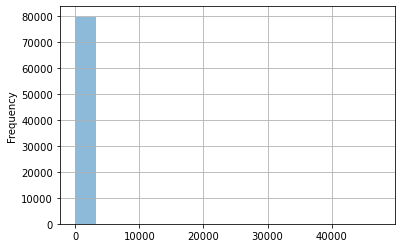

In [5]:
df['TrafficVolume'].plot.hist(alpha=0.5, bins=15, grid=True, legend=None)

In [6]:
#Traffic volume has many outliers so we need to transform them using log and very Skewed
df['TrafficVolume_log'] = [np.log(x) for x in df['TrafficVolume']]

<AxesSubplot:ylabel='Frequency'>

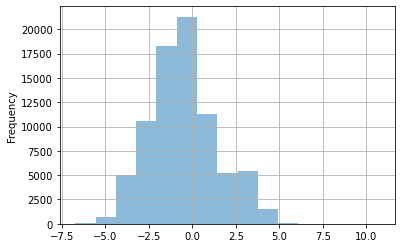

In [7]:
df['TrafficVolume_log'].plot.hist(alpha=0.5, bins=15, grid=True, legend=None)

In [8]:
#Select needed data
df = df[['time_approxmate','LocationLatitude','LocationLongitude','RadioConnectionType',
         'RadioNetworkGeneration','RadioMobileDataEnabled','RSRP','TrafficDirection','TrafficVolume_log']]

df.head(1)

,time_approxmate,LocationLatitude,LocationLongitude,RadioConnectionType,RadioNetworkGeneration,RadioMobileDataEnabled,RSRP,TrafficDirection,TrafficVolume_log
0,2019-11-02 01:45:00,24.691517,46.65258,Mobile,4G,Enabled,-94,Downlink,1.827564


In [9]:
df['Hour'] = df['time_approxmate'].dt.hour
df['Mintue'] = df['time_approxmate'].dt.minute
df = df[['Hour','Mintue','LocationLatitude','LocationLongitude','RadioConnectionType',
         'RadioNetworkGeneration','RadioMobileDataEnabled','RSRP','TrafficDirection','TrafficVolume_log']]
df.head(1)

,Hour,Mintue,LocationLatitude,LocationLongitude,RadioConnectionType,RadioNetworkGeneration,RadioMobileDataEnabled,RSRP,TrafficDirection,TrafficVolume_log
0,1,45,24.691517,46.65258,Mobile,4G,Enabled,-94,Downlink,1.827564


In [10]:
#One Hot encoding
df=pd.concat([df,pd.get_dummies(df['TrafficDirection'], drop_first=True, prefix='TrafficDirection')],axis=1).drop(['TrafficDirection'],axis=1)
df=pd.concat([df,pd.get_dummies(df['RadioMobileDataEnabled'], drop_first=True, prefix='RadioMobileDataEnabled')],axis=1).drop(['RadioMobileDataEnabled'],axis=1)
df=pd.concat([df,pd.get_dummies(df['RadioConnectionType'], drop_first=True, prefix='RadioConnectionType')],axis=1).drop(['RadioConnectionType'],axis=1)
df=pd.concat([df,pd.get_dummies(df['RadioNetworkGeneration'], drop_first=True, prefix='RadioNetworkGeneration')],axis=1).drop(['RadioNetworkGeneration'],axis=1)

df.head(1)

,Hour,Mintue,LocationLatitude,LocationLongitude,RSRP,TrafficVolume_log,TrafficDirection_Uplink,RadioMobileDataEnabled_Enabled,RadioConnectionType_Unknown,RadioConnectionType_WiFi,RadioNetworkGeneration_3G,RadioNetworkGeneration_4G
0,1,45,24.691517,46.65258,-94,1.827564,0,1,0,0,0,1


In [11]:
# Get the feature values until the target column (not included)
X = df.drop(['TrafficVolume_log'],axis=1).values.astype(np.float32)

# Get the target column
y = df['TrafficVolume_log'].values.astype(np.float32)

In [12]:
# Get 80% of the data for training; the remaining 20% will be for validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Length of train_features is: {X_train.shape}")
print(f"Length of train_labels is: {y_train.shape}")
print(f"Length of test_features is: {X_test.shape}")
print(f"Length of test_labels is: {y_test.shape}")

Length of train_features is: (63691, 11)
Length of train_labels is: (63691,)
Length of test_features is: (15923, 11)
Length of test_labels is: (15923,)


In [13]:
#N_N
Regresor_N_N = MLPRegressor()
Regresor_N_N.fit(X_train, y_train)
y__N_N_predicted = Regresor_N_N.predict(X_test)

In [14]:
mae_N_N = metrics.mean_absolute_error(y_test, y__N_N_predicted)
mse_N_N = metrics.mean_squared_error(y_test, y__N_N_predicted)
r2_N_N = metrics.r2_score(y_test, y__N_N_predicted)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae_N_N))
print('MSE is {}'.format(mse_N_N))
print('R2 score is {}'.format(r2_N_N))

The model performance for testing set
--------------------------------------
MAE is 1.3085081577301025
MSE is 2.8876307010650635
R2 score is 0.2022615763323189


In [15]:
#xgb
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)
y_xgb_predicted = xgb.predict(X_test)

In [16]:
mae_xgb = metrics.mean_absolute_error(y_test, y_xgb_predicted)
mse_xgb = metrics.mean_squared_error(y_test, y_xgb_predicted)
r2_xgb  = metrics.r2_score(y_test, y_xgb_predicted)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae_xgb ))
print('MSE is {}'.format(mse_xgb ))
print('R2 score is {}'.format(r2_xgb))

The model performance for testing set
--------------------------------------
MAE is 0.6224871873855591
MSE is 0.919834554195404
R2 score is 0.74588601074571


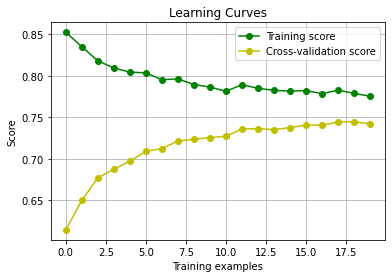

In [17]:
# It is good to randomize the data before drawing Learning Curves
def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation,:]
    Y2 = Y[permutation]
    return X2, Y2

X2, y2 = randomize(X, y)

def draw_learning_curves(X, y, estimator, num_trainings):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X2, y2, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")


    plt.legend(loc="best")

    plt.show()
    
draw_learning_curves(X, y, xgb, 20)


In [90]:
#Predict Traffic other location
print('IF RSRP is Better -41')
print ('Traffic is : {}'.format(np.exp(xgb.predict([[19,30,24.762995,46.81263,-41,0,1,0,0,1,0]]))))

IF RSRP is Better -41
Traffic is : [7.162543]


In [91]:
#Predict Traffic other location
print('IF RSRP is low -140')
print ('Traffic is : {}'.format(np.exp(xgb.predict([[19,30,24.762995,46.81263,-140,0,1,0,0,1,0]]))))

IF RSRP is low -140
Traffic is : [0.5489987]


### the test value show in this location if the RSRP is better the traffic will become High